In [1]:
import random
import sys
sys.path.insert(0,'/home/zahradnik/PycharmProjects/master_thesis')

In [2]:
from src.modules import conf, fit, df_columns, evl, preprocess
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
import haversine as hs
from gpx_converter import Converter
from datetime import datetime
from xgboost import XGBRFRegressor, XGBRegressor
import statsmodels.api as sm
warnings.simplefilter("ignore")

/home/zahradnik/PycharmProjects/master_thesis/src/modules/__init__.py
/home/zahradnik/PycharmProjects/master_thesis


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [24, 8]
plt.rcParams['figure.dpi']

100.0

In [5]:
# race_day = datetime.strptime('2022-10-08-10-30', '%Y-%m-%d-%H-%M') # Hradec
race_day = datetime.strptime('2023-03-26-12-00', '%Y-%m-%d-%H-%M') # PALESTRA

In [6]:
data = fit.load_pcls(
        athlete_name='zahradnik',
        activity_type='running',
        path_to_load=conf["Paths"]["pcl"],
    )

100%|██████████| 377/377 [00:01<00:00, 359.88it/s]


In [7]:
data.to_csv("train.csv")

AttributeError: 'list' object has no attribute 'to_csv'

In [340]:
low_dist = []
high_dist = []
for act in data:
    if np.max(act.distance) > 10000:
        high_dist.append(act)
    else:
        low_dist.append(act)
len(low_dist),len(high_dist)

(125, 252)

In [341]:
train_df = fit.clean_data(pd.concat(data))
len(train_df)

1028397

In [342]:
speed_train = train_df.enhanced_speed
heart_train = train_df.heart_rate
cad_train = train_df.cadence

train_df.drop("enhanced_speed",axis=1,inplace=True)
train_df.drop("heart_rate",axis=1,inplace=True)
train_df.drop("cadence",axis=1,inplace=True)

In [343]:
df = Converter(input_file='hradec_mapy.gpx').gpx_to_dataframe()
df['enhanced_altitude'] = df.altitude
df.drop("altitude",axis=1,inplace=True)

In [344]:
def calc_dist(pos1: tuple,pos2: tuple) -> int:
    return hs.haversine(pos1, pos2, unit=hs.Unit.METERS)

In [345]:
## DISTANCE
df['dist_diff'] = [0] + [calc_dist(
    (df['latitude'].iloc[x], df['longitude'].iloc[x]),
    (df['latitude'].iloc[x+1], df['longitude'].iloc[x+1])) for x in range(len(df)-1)]

df['distance'] = df['dist_diff'].cumsum()

In [346]:
np.max(df.distance)

21062.858815659685

In [347]:
df["temp"], df["humidity"], df["rain"], df["snow"], df["wind_speed"] = preprocess.get_meteo(
    df.latitude.iloc[0],
    df.longitude.iloc[0],
    df.enhanced_altitude.iloc[0],
    datetime.strptime('2023-03-26-12-00', '%Y-%m-%d-%H-%M')
)
df.drop(['latitude','longitude'],axis=1,inplace=True)

In [348]:
df["slope_ascent"], df["slope_descent"] = preprocess.calc_ascent_descent(df)

df["slope_steep"] = preprocess.calc_slope_steep(df)

In [349]:
df["enhanced_altitude_delayed"] = preprocess.calc_delayed(df.enhanced_altitude, window=1)

In [350]:
df['hr_zone'] = 5
# df.set_index(["time"], inplace=True)

In [351]:
test_df= df

In [352]:
#test_df = preprocess.calc_dt(test_df, cols=['month','week','hour','minute','second'],date=race_day)

In [353]:
len(train_df.columns),len(test_df.columns)

(124, 13)

In [354]:
test_df= preprocess.calc_windows(df=test_df,
          lagged=3,
          cols=["slope_steep", "slope_ascent", "slope_descent"])

In [355]:
len(train_df[test_df.columns].columns),len(test_df.columns)

(19, 19)

# Cadence

In [356]:
from sklearn.linear_model import Ridge, LinearRegression, RidgeCV, ElasticNetCV, LassoCV
clf = XGBRegressor()
percent_delay = int(len(test_df) * 0.02)  ## 2% delay
clf.fit(train_df[test_df.columns], cad_train)
y_pred_cad = clf.predict(test_df)
#y_pred_cad = [x if 85 < x < 100 else y_pred_cad.mean() for x in y_pred_cad]

In [357]:
train_df['cadence'] = cad_train
test_df['cadence'] = y_pred_cad
len(train_df.columns),len(test_df.columns)

(125, 20)

In [358]:
np.mean(y_pred_cad)

92.57197

In [359]:
test_df= preprocess.calc_windows(df=test_df,
          lagged=3,
          cols=["cadence"])
# test_df = preprocess.calc_moving(df=test_df, max_range=110, col="cadence")

# Heart Rate

In [360]:
clf = XGBRegressor()
percent_delay = int(len(test_df) * 0.02)  ## 2% delay
clf.fit(train_df[test_df.columns], heart_train)
y_pred_hr = clf.predict(test_df)

In [361]:
np.mean(y_pred_hr)

175.74287

In [362]:
train_df['heart_rate'] = heart_train
test_df['heart_rate'] = y_pred_hr
len(train_df.columns),len(test_df.columns)

(126, 23)

In [363]:
test_df= preprocess.calc_windows(df=test_df,
          lagged=3,
          cols=["heart_rate"])
#test_df = preprocess.calc_moving(df=test_df, max_range=110, col="heart_rate")

In [364]:
clf = XGBRegressor()
percent_delay = int(len(test_df) * 0.02)  ## 2% delay
clf.fit(train_df[test_df.columns], speed_train)
y_pred_ridge = clf.predict(test_df)

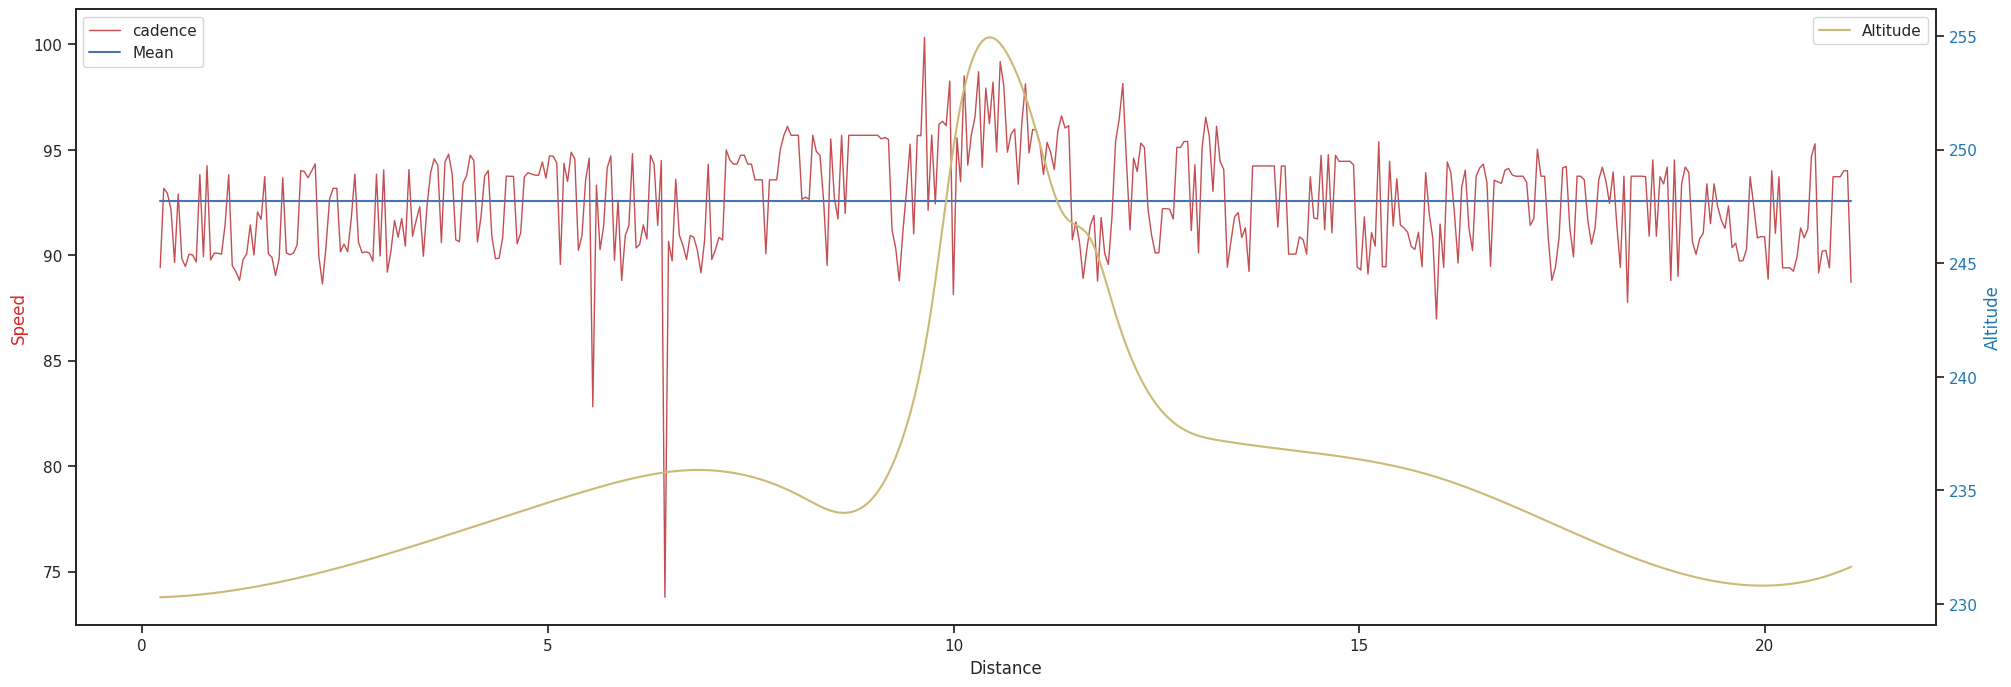

In [365]:
_, _ = evl.plot(df=test_df[percent_delay:],pred=test_df['cadence'][percent_delay:],endog = "cadence")

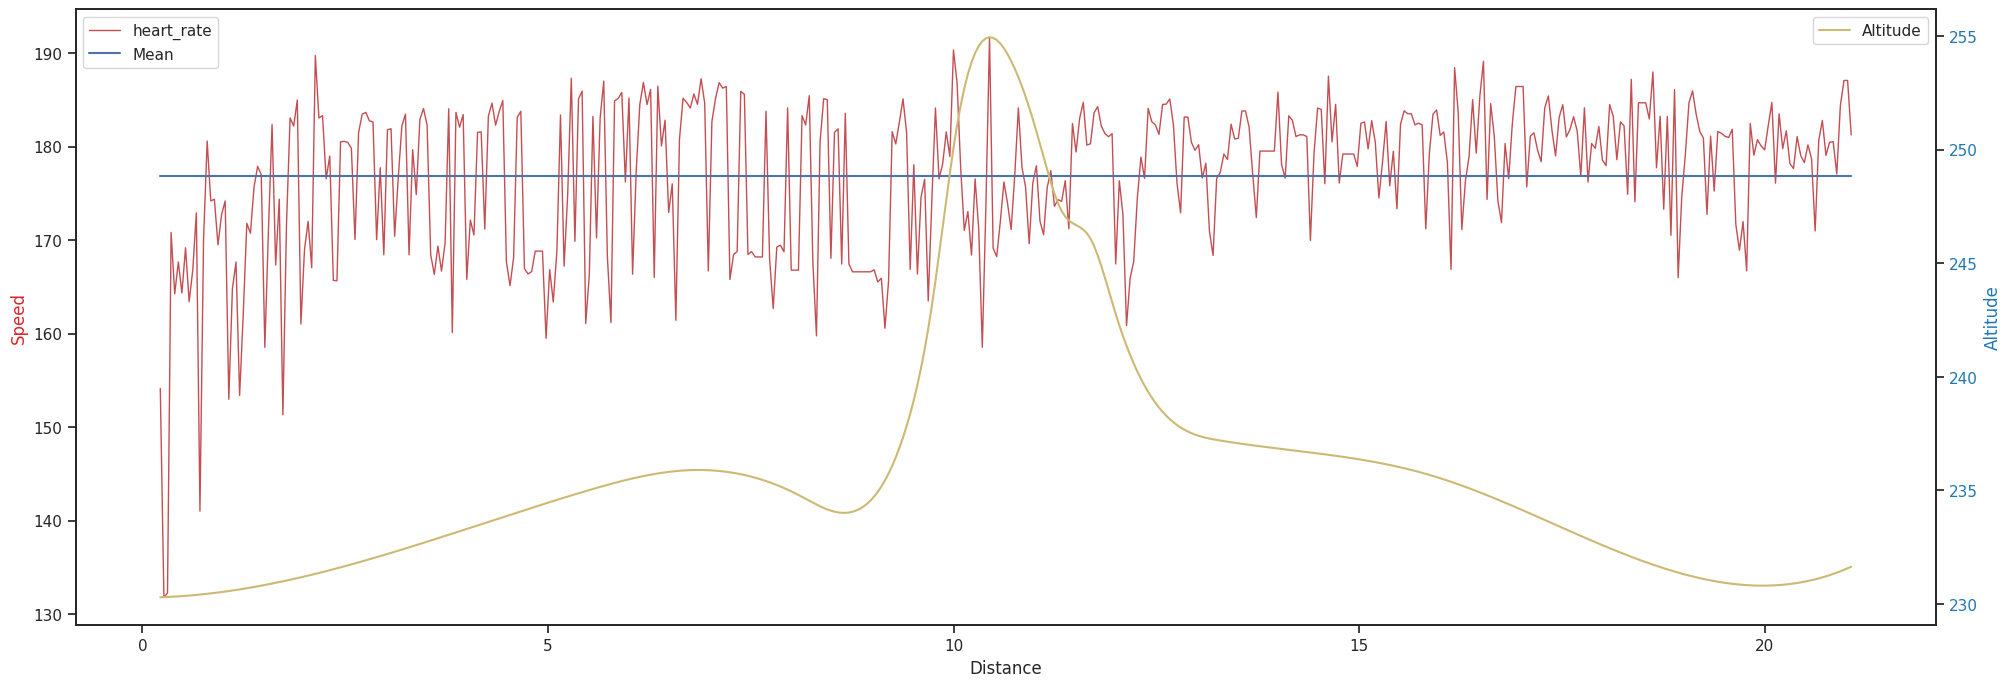

In [366]:
_, _ = evl.plot(df=test_df[percent_delay:],pred=test_df['heart_rate'][percent_delay:],endog = "heart_rate")

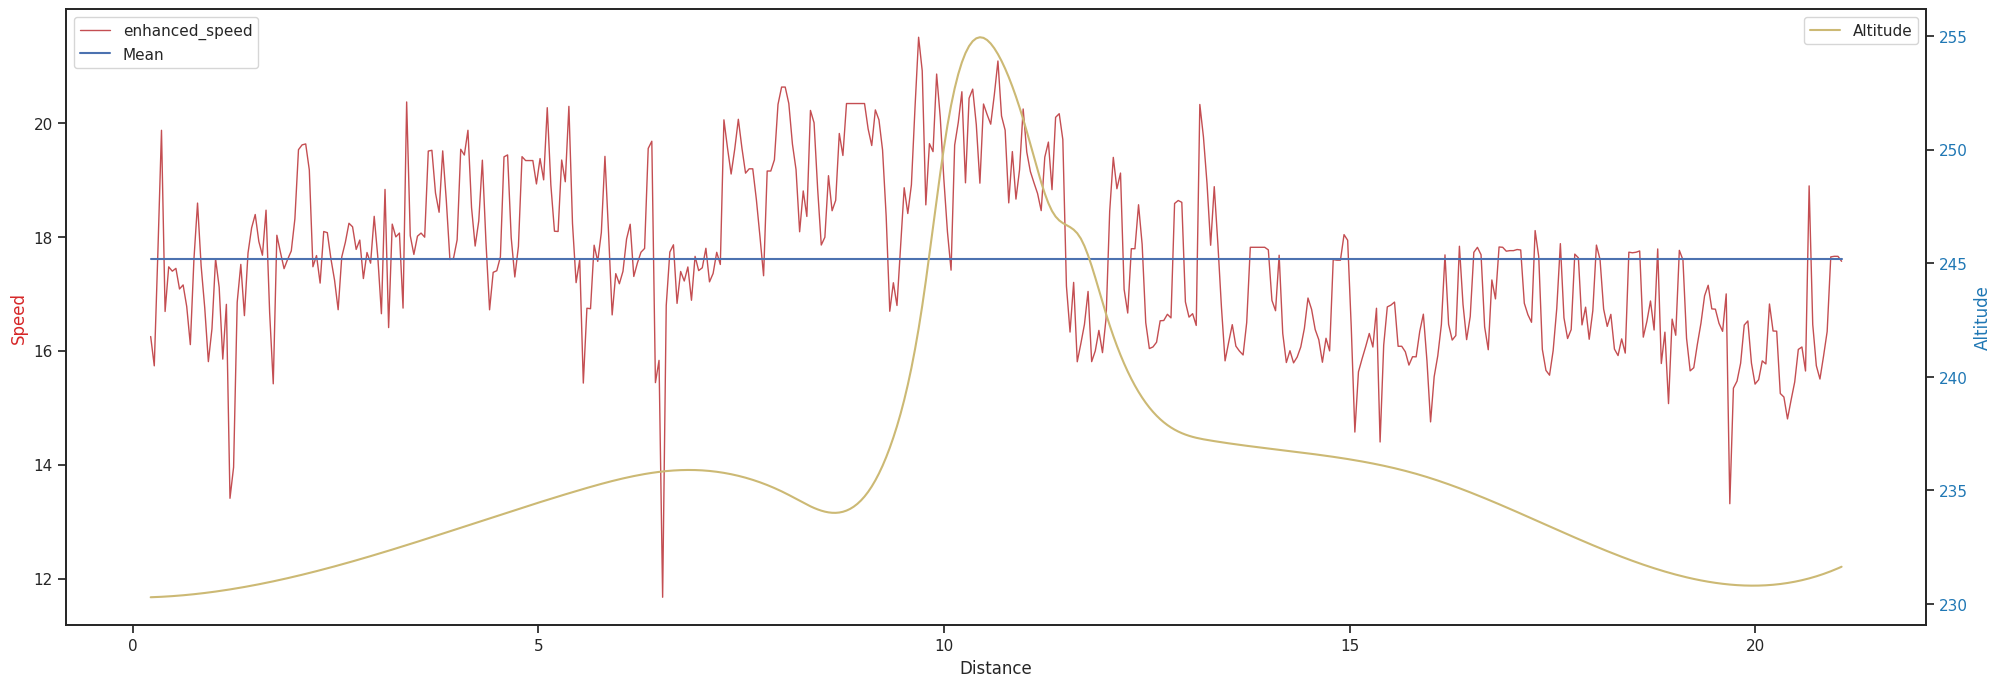

In [367]:
_, _ = evl.plot(df=test_df[percent_delay:],pred=y_pred_ridge[percent_delay:],endog = "enhanced_speed")

In [368]:
np.mean(test_df.cadence), np.mean(test_df.heart_rate)

(92.57197, 175.74287)

In [369]:
y_pred_ridge = [x if x > 15 else np.mean(y_pred_ridge) or x if x < 30 else np.mean(y_pred_ridge) for x in y_pred_ridge]

In [370]:
import math

# np.mean(speed_test), np.mean(y_pred_ridge), max(test_df.distance)
time = ((np.max(test_df.distance) / 1000) / np.mean(y_pred_ridge)) * 60
minutes = math.floor(time)
seconds = round((time - minutes) * 60)
if seconds == 60:
    seconds=0
    minutes+=1
f'Final time: {minutes}:{seconds}'

'Final time: 71:28'

ValueError: 'c' argument has 480 elements, which is inconsistent with 'x' and 'y' with size 337.

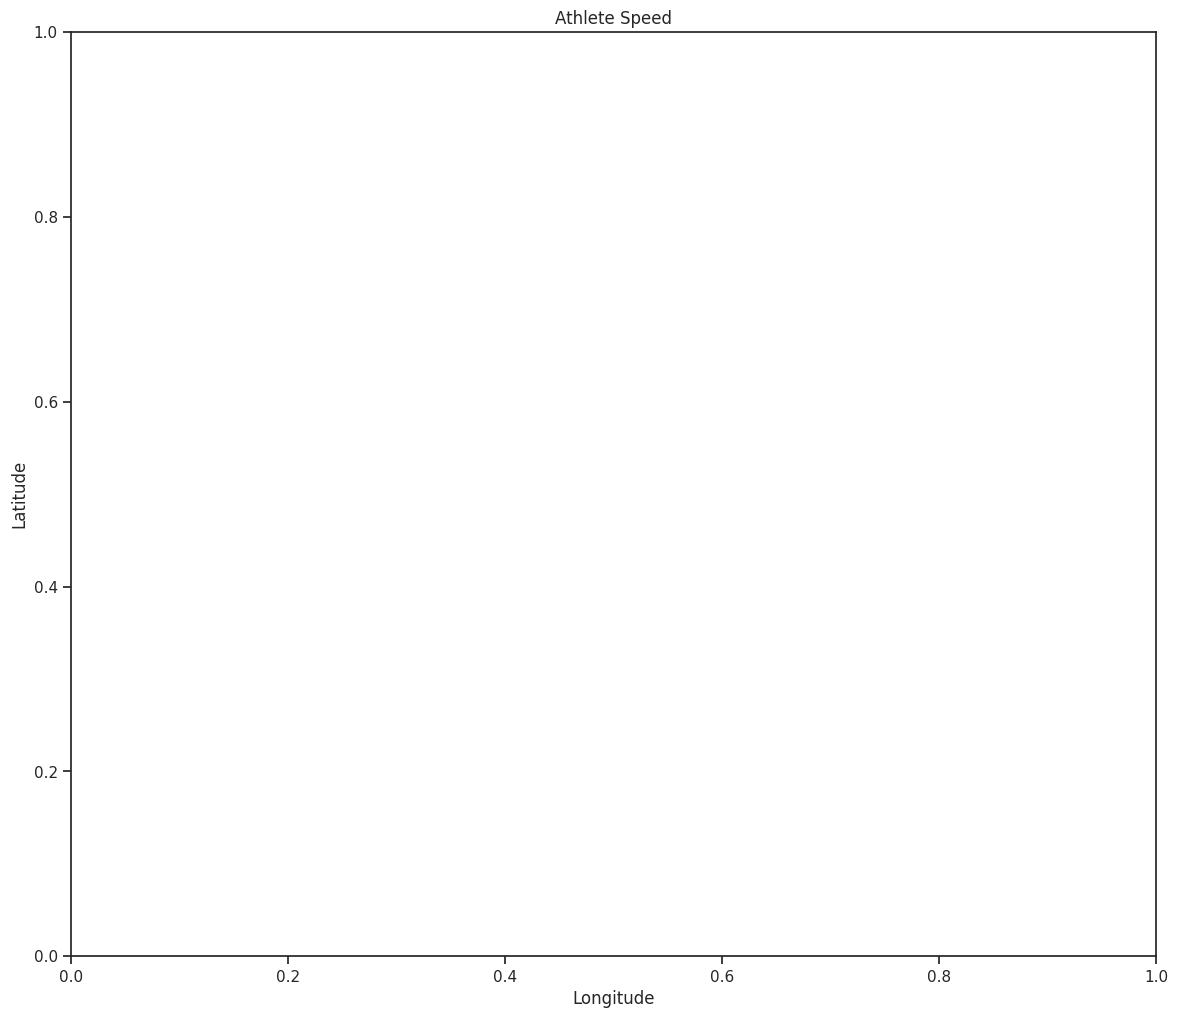

In [371]:
df_map = Converter(input_file='kbely_mapy.gpx').gpx_to_dataframe()
lons = df_map.longitude
lats = df_map.latitude
speed = y_pred_ridge

plt.figure(figsize = (14, 12))
plt.title('Athlete Speed')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(lons, lats, c = speed)
cbar = plt.colorbar()
cbar.set_label('Speed')

In [ ]:
import folium
from branca.element import Figure
from folium import plugins
fig5=Figure(height=550,width=750)
map=folium.Map(location=[df_map.latitude[0], df_map.longitude[0]],tiles='cartodbpositron',zoom_start=14)
fig5.add_child(map)

coords = [[x,y] for x,y in zip(df_map.latitude, df_map.longitude)]
f1=folium.FeatureGroup("Athlete")
line_1=folium.vector_layers.PolyLine(coords,popup='<b>Path of the athlete/b>',tooltip='Athlete',color='blue',weight=10).add_to(f1)
f1.add_to(map)
folium.LayerControl().add_to(map)

map

In [ ]:
max = 255/np.max(y_pred_ridge)
speed = [int(max * x) for x in y_pred_ridge]

def rgb_to_hex(rgb):
    return '%02x%02x%02x' % rgb

In [ ]:
my_map=folium.Map(location=[df_map.latitude[0], df_map.longitude[0]],tiles='cartodbpositron',zoom_start=14)


# for lat,long in zip(df_map.latitude, df_map.longitude):
#     folium.Marker([lat, long], tooltip="Kbely").add_to(my_map)

for x, sped in zip(range(len(coords)),speed):
    folium.PolyLine(
        coords[x:x+2],
        color=f"#{rgb_to_hex((sped,50,100))}",
        weight=10
    ).add_to(my_map)

my_map

In [ ]:
hex(int(y_pred_ridge[32]))